## Modeling for predicting hospitalization at ED triage

In [1]:
!ls

data_general_processing.ipynb
data_general_processing.py
dataset_path.py
embedding_critical_v10
embedding_hospitalization_v10
embedding.py
embedding_revisit_v10
extract_icd.ipynb
extract_master_dataset-haotesting-v1.ipynb
extract_master_dataset.ipynb
extract_master_dataset.py
helpers.py
hospitalization_triage_mlp
medcodes
medcode_utils.py
__pycache__
task1_logreg.pickle
Task_1_Model_hospitalization_triage.ipynb
Task_2_Model_critical_triage.ipynb
Task_3_Model_72h_ed_revisit_disposition.ipynb
Task_4_Appendix_Model_critical_triage_disposition.ipynb
utils.py


In [2]:
output_path = '/home/wenglab/projects/mimic_iv/mimic4ed-benchmark/output/data/'

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [3]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve

# from dataset_path import output_path

path = output_path
output_path = os.path.join(path, "Figure3")
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed=0

In [4]:
random.seed(random_seed)
np.random.seed(random_seed)

In [5]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,185878,14173731,25558213.0,37567532,2183-04-07 19:33:00,2183-04-08 03:33:00,F,WHITE,WALK IN,ADMITTED,51,2183,NaN,2183-04-08 01:52:00,2183-04-15 15:35:00,NaN,WHITE,2183-04-07 19:33:00,2183-04-08 03:33:00,Other,2183,51,False,0 days 08:00:00,NaN,NaN,False,True,False,0,0,0,2183-07-07 00:36:00,89 days 21:03:00,False,0,0,0,0,0,0,8.00,NaN,89.88,36.333333,105.0,20.0,100.0,141.0,84.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.444444,80.0,16.0,95.0,106.0,70.0,2.0,3.0,6.0,103.000000,1,0,2,1,1,2
1,194353,14353044,NaN,38915834,2170-07-31 19:31:00,2170-07-31 23:11:00,M,WHITE,AMBULANCE,HOME,75,2166,2175-09-23,NaN,NaN,NaN,WHITE,NaN,NaN,NaN,2170,79,False,0 days 03:40:00,NaN,NaN,False,False,False,0,0,2,2170-08-21 22:56:00,20 days 23:45:00,False,0,0,1,0,0,0,3.67,NaN,20.99,38.000000,89.0,16.0,99.0,113.0,60.0,...,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,37.722222,88.0,16.0,96.0,113.0,62.0,0.0,1.0,28.0,77.666667,14,9,6,1,1,1
2,20783,10471160,NaN,35664949,2112-06-07 19:06:00,2112-06-07 22:05:00,M,WHITE,WALK IN,HOME,75,2111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2112,76,False,0 days 02:59:00,NaN,NaN,False,False,False,0,0,1,NaN,NaN,False,0,0,0,0,0,0,2.98,NaN,NaN,37.000000,78.0,16.0,98.0,104.0,79.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.777778,76.0,16.0,94.0,119.0,66.0,0.0,0.0,8.0,87.333333,3,9,6,1,1,1
3,227704,15106749,NaN,30191936,2131-03-26 12:22:00,2131-03-26 16:36:00,M,WHITE - OTHER EUROPEAN,WALK IN,HOME,80,2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2131,85,False,0 days 04:14:00,NaN,NaN,False,False,False,0,0,0,2135-02-10 10:26:00,1416 days 17:50:00,False,0,0,0,0,0,0,4.23,NaN,1416.74,35.555556,60.0,18.0,95.0,141.0,68.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.611111,56.0,16.0,97.0,136.0,70.0,4.0,0.0,7.0,92.333333,4,9,8,2,1,1
4,414477,19255976,23983495.0,38973873,2148-10-08 17:20:00,2148-10-09 13:55:00,F,WHITE,AMBULANCE,HOME,73,2148,NaN,2148-10-08 22:29:00,2148-10-09 13:55:00,NaN,WHITE,2148-10-08 17:20:00,2148-10-09 13:55:00,Other,2148,73,False,0 days 20:35:00,NaN,NaN,False,True,False,1,1,1,NaN,NaN,False,0,0,0,0,0,0,20.58,NaN,NaN,38.611111,96.0,16.0,96.0,151.0,108.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,81.0,19.0,97.0,126.0,76.0,1.0,2.0,5.0,122.333333,3,9,7,2,2,3


### 1. Task-specific filter: No task-specific exclusion needed

In [6]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 352307 , testing size = 88077


### 2. Variable Selection

In [7]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [8]:
df_train.columns.to_list()

['index',
 'subject_id',
 'hadm_id',
 'stay_id',
 'intime',
 'outtime',
 'gender',
 'race',
 'arrival_transport',
 'disposition',
 'anchor_age',
 'anchor_year',
 'dod',
 'admittime',
 'dischtime',
 'deathtime',
 'ethnicity',
 'edregtime',
 'edouttime',
 'insurance',
 'in_year',
 'age',
 'outcome_inhospital_mortality',
 'ed_los',
 'intime_icu',
 'time_to_icu_transfer',
 'outcome_icu_transfer_12h',
 'outcome_hospitalization',
 'outcome_critical',
 'n_ed_30d',
 'n_ed_90d',
 'n_ed_365d',
 'next_ed_visit_time',
 'next_ed_visit_time_diff',
 'outcome_ed_revisit_3d',
 'n_hosp_30d',
 'n_hosp_90d',
 'n_hosp_365d',
 'n_icu_30d',
 'n_icu_90d',
 'n_icu_365d',
 'ed_los_hours',
 'time_to_icu_transfer_hours',
 'next_ed_visit_time_diff_days',
 'triage_temperature',
 'triage_heartrate',
 'triage_resprate',
 'triage_o2sat',
 'triage_sbp',
 'triage_dbp',
 'triage_pain',
 'triage_acuity',
 'chiefcomplaint',
 'chiefcom_chest_pain',
 'chiefcom_abdominal_pain',
 'chiefcom_headache',
 'chiefcom_shortness_of_br

In [9]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [10]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [11]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [12]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.8999358251856485 : 1


### 3.  Modeling script

In [13]:
# Containers for all results
result_list = []

Logistic Regression:


/home/wenglab/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 6.281232595443726 seconds
AUC: 0.8107631364977872
AUPRC: 0.7765640770445182
Sensitivity: 0.746351900377431
Specificity: 0.7251936316695353
Score thresold: 0.4496671923468405
2.5 97.5


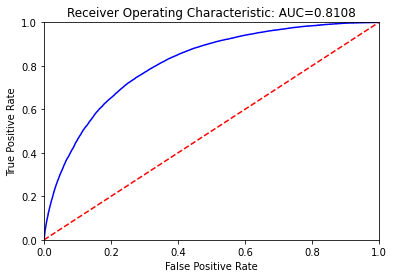

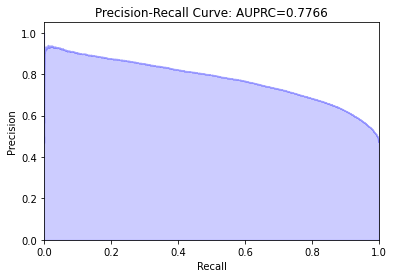

In [14]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task1_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 76.05992579460144 seconds
AUC: 0.8211597257050967
AUPRC: 0.7888421551871336
Sensitivity: 0.755775656898334
Specificity: 0.7308734939759036
Score thresold: 0.4804684898434899
2.5 97.5


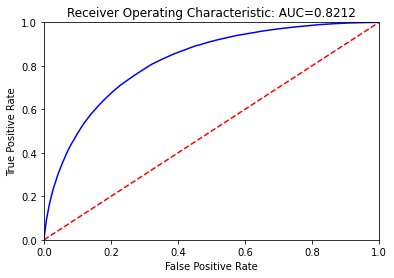

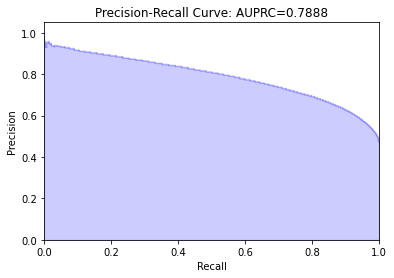

[0.12709663 0.01304367 0.00757568 0.01120353 0.02217615 0.00616102
 0.01483551 0.0267712  0.00079684 0.00174104 0.00505327 0.07842526
 0.08583637 0.04026746 0.04223199 0.08698217 0.08307585 0.0472148
 0.11214038 0.00704657 0.00902989 0.00509473 0.00050909 0.00421605
 0.00282391 0.00388997 0.00435992 0.00339942 0.00417298 0.00337507
 0.00568746 0.00300146 0.00301887 0.00141463 0.00624559 0.00216036
 0.00152101 0.0037478  0.00586223 0.00344265 0.00126117 0.00585346
 0.00448977 0.00144071 0.00203854 0.00104693 0.00823475 0.00276303
 0.0024386  0.0046556  0.01043574 0.0045332  0.00423864 0.000942
 0.00389833 0.00484244 0.00348942 0.01274722 0.00115494 0.00335603
 0.00485518 0.00408287 0.00281872 0.00773425]


In [15]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 70.93339228630066 seconds
AUC: 0.8209878450331778
AUPRC: 0.7952767559776245
Sensitivity: 0.7480587542370845
Specificity: 0.738145438898451
Score thresold: 0.4831440688230021
2.5 97.5


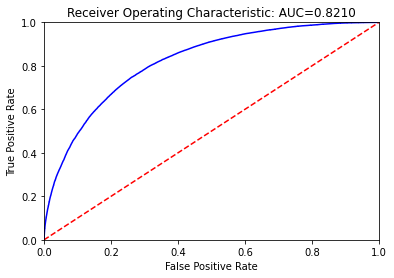

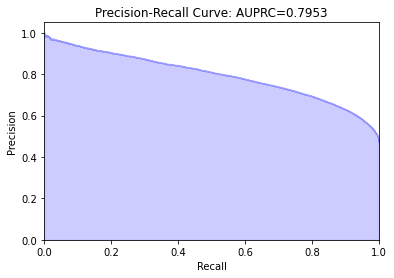

In [16]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [17]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [18]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1762/1762 [==============================] - 8s 4ms/step - loss: 0.5716 - accuracy: 0.7105 - auc: 0.7791 - auprc: 0.7441 - true_positives: 111902.0000 - true_negatives: 138411.0000 - precision: 0.7041 - recall: 0.6706
Epoch 2/20
1762/1762 [==============================] - 6s 4ms/step - loss: 0.5416 - accuracy: 0.7268 - auc: 0.8016 - auprc: 0.7717 - true_positives: 116321.0000 - true_negatives: 139736.0000 - precision: 0.7180 - recall: 0.6971
Epoch 3/20
1762/1762 [==============================] - 6s 4ms/step - loss: 0.5361 - accuracy: 0.7305 - auc: 0.8058 - auprc: 0.7764 - true_positives: 117617.0000 - true_negatives: 139738.0000 - precision: 0.7202 - recall: 0.7048
Epoch 4/20
1762/1762 [==============================] - 6s 4ms/step - loss: 0.5328 - accuracy: 0.7325 - auc: 0.8082 - auprc: 0.7797 - true_positives: 118323.0000 - true_negatives: 139732.0000 - precision: 0.7214 - recall: 0.7090
Epoch 5/20
1762/1762 [==============================] - 6s 4ms/step - loss: 0.5317 -

MLP:
2753/2753 [==============================] - 3s 1ms/step
AUC: 0.8255689892157174
AUPRC: 0.8002020944422468
Sensitivity: 0.7518811452748997
Specificity: 0.7416953528399312
Score thresold: 0.48262584
2.5 97.5


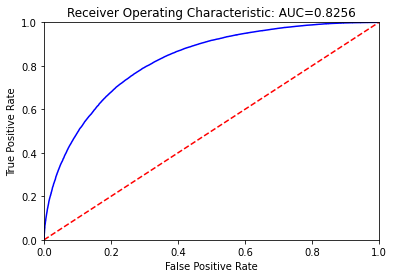

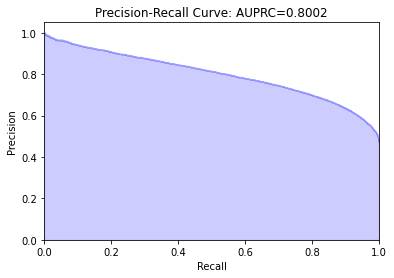

In [19]:
print("MLP:")
mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [20]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


esi
AUC: 0.7103505611296028
AUPRC: 0.6298074851429615
Sensitivity: 0.5817486837993124
Specificity: 0.7835197934595525
Score thresold: -2.0
2.5 97.5


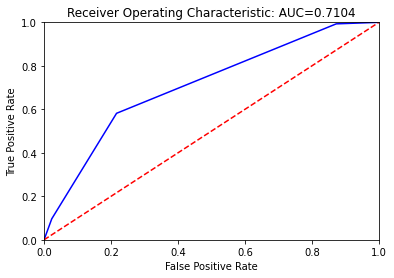

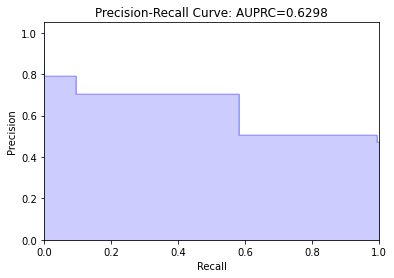

In [21]:
df_test["esi"] = -df_test["triage_acuity"]
get_score_performance("esi", random_seed=random_seed)

In [ ]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore)
AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_Hospitalization.csv')))
df_test["AutoScore"] = AutoScore_pred["pred_score"]

AutoScore
AUC: 0.7934874565329351
AUPRC: 0.7562489562156791
Sensitivity: 0.7215804453373514
Specificity: 0.7209097168431018
Score thresold: 45
2.5 97.5


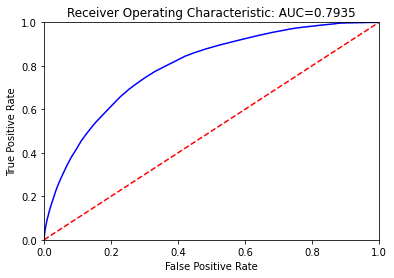

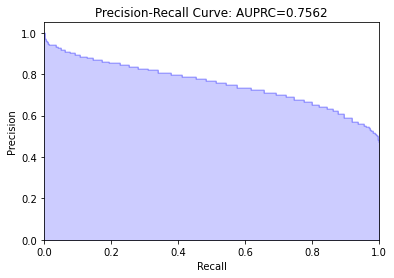

In [20]:
get_score_performance("AutoScore", random_seed=random_seed) 

score_NEWS
AUC: 0.5830541413953252
AUPRC: 0.5571178498926838
Sensitivity: 0.5674207274563069
Specificity: 0.5421901893287435
Score thresold: 1
2.5 97.5


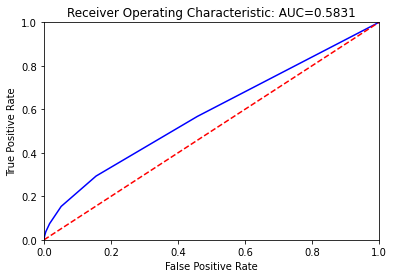

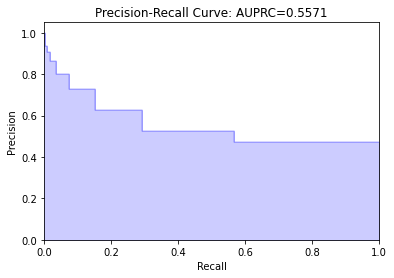

In [22]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.5648640976938916
AUPRC: 0.5388416890002937
Sensitivity: 0.5206385075846816
Specificity: 0.5654259896729776
Score thresold: 1
2.5 97.5


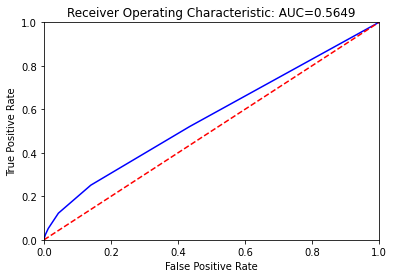

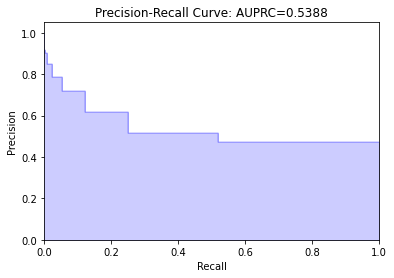

In [23]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6728548904853253
AUPRC: 0.6076516125841411
Sensitivity: 0.7179363896434839
Specificity: 0.5599397590361446
Score thresold: 3
2.5 97.5


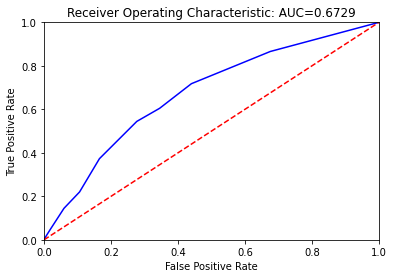

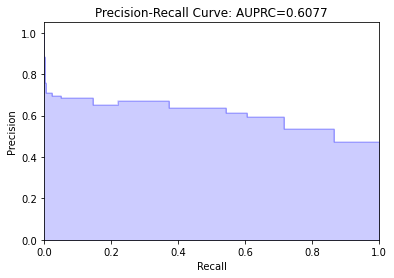

In [24]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.5591784089503674
AUPRC: 0.522181469960859
Sensitivity: 0.29982931461403467
Specificity: 0.8102409638554217
Score thresold: 2
2.5 97.5


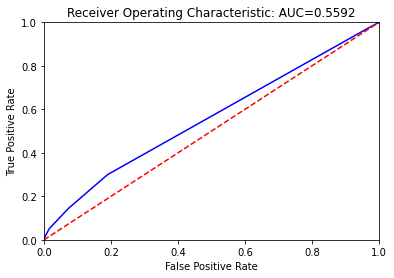

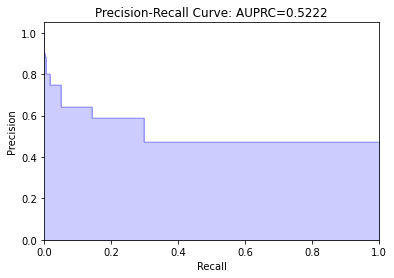

In [25]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.6760314715222786
AUPRC: 0.6197396946065172
Sensitivity: 0.7044979205231147
Specificity: 0.5839070567986231
Score thresold: 4
2.5 97.5


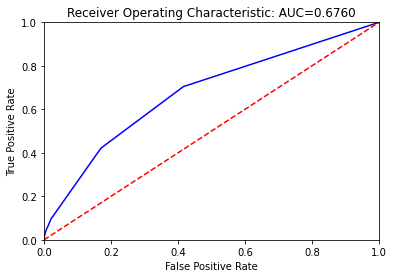

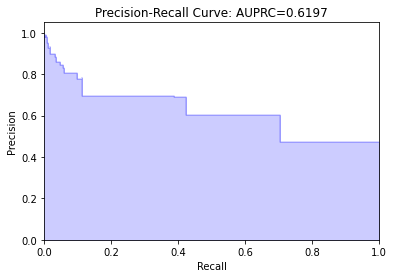

In [26]:
get_score_performance("score_CART", random_seed=random_seed)

In [27]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from embedding import *
# from importlib import reload
# reload(embedding)

In [28]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


Model: "embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 icd_input (InputLayer)         [(None, 15151)]      0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15151, 1024)  15515648    ['icd_input[0][0]']              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None, 1024)        0           ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 dense_3 (Dense)                (None, 256)          262400      ['tf.math.reduce_su

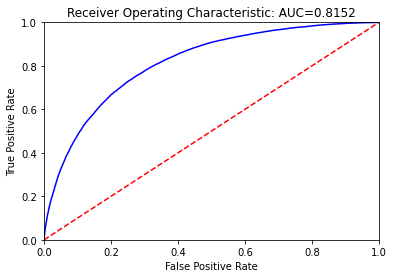

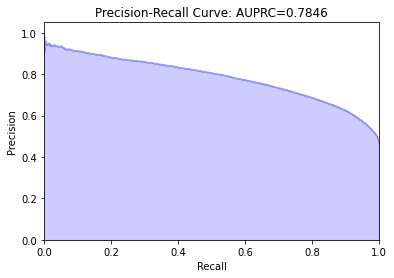

In [29]:
# To train from scratch, set load_model to None
load_model = None#"embedding_hospitalization_"+version 
save_model = "embedding_hospitalization_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299 # to be updated
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [29]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.446,0.806 (0.803-0.809),0.77 (0.765-0.775),0.747 (0.722-0.749),0.721 (0.719-0.745),3.715
1,RF,0.490,0.819 (0.819-0.822),0.787 (0.785-0.79),0.754 (0.742-0.767),0.734 (0.724-0.747),57.910
2,GB,0.474,0.819 (0.817-0.822),0.793 (0.79-0.797),0.754 (0.736-0.759),0.729 (0.727-0.752),60.027
3,MLP,0.457,0.822 (0.821-0.825),0.796 (0.793-0.8),0.757 (0.745-0.767),0.734 (0.724-0.746),171.052
4,esi,-2.000,0.711 (0.709-0.714),0.632 (0.628-0.636),0.582 (0.578-0.586),0.784 (0.781-0.787),0.000
5,AutoScore,45.000,0.793 (0.791-0.797),0.756 (0.753-0.76),0.722 (0.717-0.749),0.721 (0.698-0.725),0.000
6,score_NEWS,1.000,0.581 (0.579-0.584),0.555 (0.552-0.559),0.565 (0.561-0.57),0.54 (0.537-0.544),0.000
7,score_NEWS2,1.000,0.563 (0.56-0.566),0.538 (0.534-0.541),0.519 (0.514-0.522),0.563 (0.559-0.567),0.000
8,score_REMS,3.000,0.672 (0.669-0.675),0.61 (0.605-0.613),0.714 (0.709-0.716),0.564 (0.559-0.568),0.000
9,score_MEWS,2.000,0.559 (0.557-0.562),0.522 (0.518-0.526),0.3 (0.296-0.302),0.81 (0.808-0.813),0.000


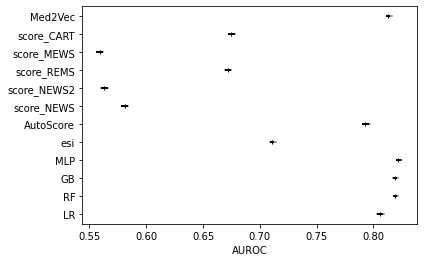

In [30]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_hosp.eps', my_path = output_path) 

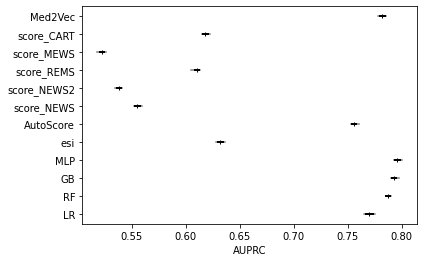

In [31]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_hosp.eps', my_path = output_path)

In [32]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.126553
18,triage_acuity,0.111814
15,triage_sbp,0.087156
12,triage_heartrate,0.085326
16,triage_dbp,0.082793
11,triage_temperature,0.078387
17,triage_pain,0.046876
14,triage_o2sat,0.042483
13,triage_resprate,0.040160
7,n_hosp_365d,0.027609
